<a href="https://colab.research.google.com/github/ThalyaGIT/UK-Music-Index-Returns/blob/main/3_data-analysis_notebooks/This_is_working_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [328]:
# @title
# Import packages
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.mstats import winsorize
from scipy.stats import zscore

print("Packages have been imported...")


Packages have been imported...


In [329]:
# @title
# Open CSV into dataframe
url_1_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_1_days.csv'
url_3_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_3_days.csv'
url_5_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_5_days.csv'
url_10_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_10_days.csv'
url_20_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_20_days.csv'

df_1_day = pd.read_csv(url_1_day)
df_3_day = pd.read_csv(url_3_day)
df_5_day = pd.read_csv(url_5_day)
df_10_day = pd.read_csv(url_10_day)
df_20_day = pd.read_csv(url_20_day)


# Open CSV into dataframe with TED
url_1_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_1_days_TED.csv'
url_3_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_3_days_TED.csv'
url_5_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_5_days_TED.csv'
url_10_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_10_days_TED.csv'
url_20_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_20_days_TED.csv'

df_1_day_TED = pd.read_csv(url_1_day_TED)
df_3_day_TED = pd.read_csv(url_3_day_TED)
df_5_day_TED = pd.read_csv(url_5_day_TED)
df_10_day_TED = pd.read_csv(url_10_day_TED)
df_20_day_TED = pd.read_csv(url_20_day_TED)

print("data has been loaded....")



data has been loaded....


# **Main Regression Results**

In [330]:
# @title
## Main Script

# Initialize an empty list to store results
results = []

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [5]
#days_list = [1, 3, 5, 10]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract the month from the 'Date' column
        df['Month'] = df['Date'].dt.month

        # Create dummy variables for the months
        month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)

        # Convert boolean dummy variables to integers
        month_dummies = month_dummies.astype(int)

        # Define the dependent variable
        y = df[f'% {index} Change']

        # Define the independent variables
        X = df[['Change in SWAV',
                'ADS_Change',
                'EPU_Change',
                f'Previous % {index} Change',
                '% MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC']]

        # Add the month dummies to the independent variables
        X = pd.concat([X, month_dummies], axis=1)

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # vif_data = pd.DataFrame()
            # vif_data['feature'] = X.columns
            # vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            # print(vif_data)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))
        else:
            result_row.append((None, None))  # Store None for both if no valid data

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Days']
for index in indices:
    columns.extend([f'{index} Coef'])  # Ensure you have columns for coefficients only

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: green')
                elif coef < 0:
                    colors.append('background-color: red')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

print("Multicollinearity checks done")
# Display the styled DataFrame
styled_df


Multicollinearity checks done


,Days,FTSE100 Coef,FTSE250 Coef,FTSESmallCap Coef
0,5,-7.100000,-3.410000,0.450000


# **Distribution of Change in SWAV**

The bar chart reveals significant monthly variations in "Change in SWAV," especially during the festive season at year-end. These fluctuations likely distort the data, so I will see how the regression looks like when I  remove festive periods. Doing so will clarify the true relationship between SWAV changes and index returns.

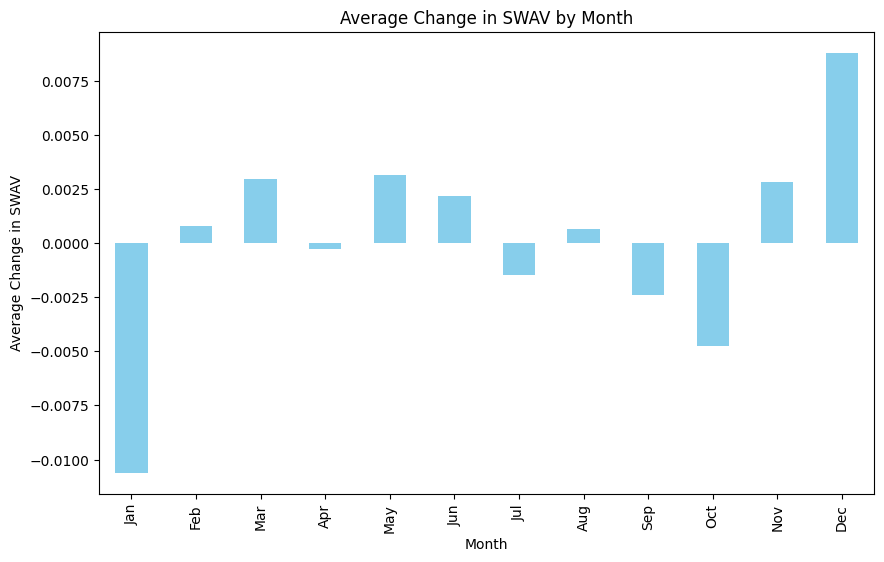

In [331]:
# @title
# Ensure 'Date' column is in datetime format
df_5_day['Date'] = pd.to_datetime(df_5_day['Date'])

# Extract the month from the 'Date' column
df_5_day['Month'] = df_5_day['Date'].dt.month

# Calculate the average 'Change in SWAV' by month
monthly_avg = df_5_day.groupby('Month')['Change in SWAV'].mean()

# Plot the average 'Change in SWAV' by month
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Change in SWAV by Month')
plt.xlabel('Month')
plt.ylabel('Average Change in SWAV')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# **Remove Festive Data**

In [332]:
# @title
## Main Script

# Initialize an empty list to store results
results = []

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [5]
#days_list = [1, 3, 5, 10]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract the month from the 'Date' column
        df['Month'] = df['Date'].dt.month

        df = df[df['festive'] == 0]

        # Create dummy variables for the months
        month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)

        # Convert boolean dummy variables to integers
        month_dummies = month_dummies.astype(int)

        # Define the dependent variable
        y = df[f'% {index} Change']

        # Define the independent variables
        X = df[['Change in SWAV',
                'ADS_Change',
                'EPU_Change',
                f'Previous % {index} Change',
                '% MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC']]

        # Add the month dummies to the independent variables
        X = pd.concat([X, month_dummies], axis=1)

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # vif_data = pd.DataFrame()
            # vif_data['feature'] = X.columns
            # vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            # print(vif_data)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))
        else:
            result_row.append((None, None))  # Store None for both if no valid data

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Days']
for index in indices:
    columns.extend([f'{index} Coef'])  # Ensure you have columns for coefficients only

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: green')
                elif coef < 0:
                    colors.append('background-color: red')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

print("Multicollinearity checks done")
# Display the styled DataFrame
styled_df


Multicollinearity checks done


,Days,FTSE100 Coef,FTSE250 Coef,FTSESmallCap Coef
0,5,-6.410000,0.620000,5.510000


# **New Control fo Covid Stringency**

In [333]:
# @title
## Main Script

# Initialize an empty list to store results
results = []

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [5]
#days_list = [1, 3, 5, 10]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract the month from the 'Date' column
        df['Month'] = df['Date'].dt.month

        df = df[df['festive'] == 0].copy()

        df['Covid_Stringency*SWAV'] = df['Change in SWAV']*df['Stringency_Change']

        # Create dummy variables for the months
        month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)

        # Convert boolean dummy variables to integers
        month_dummies = month_dummies.astype(int)

        # Define the dependent variable
        y = df[f'% {index} Change']

        # Define the independent variables
        X = df[['Change in SWAV',
                'ADS_Change',
                'EPU_Change',
                f'Previous % {index} Change',
                '% MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC',
                'Stringency_Change',
                'Covid_Stringency*SWAV'
                ]]

        # Add the month dummies to the independent variables
        X = pd.concat([X, month_dummies], axis=1)

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # vif_data = pd.DataFrame()
            # vif_data['feature'] = X.columns
            # vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            # print(vif_data)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))
        else:
            result_row.append((None, None))  # Store None for both if no valid data

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Days']
for index in indices:
    columns.extend([f'{index} Coef'])  # Ensure you have columns for coefficients only

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: green')
                elif coef < 0:
                    colors.append('background-color: red')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

print("Multicollinearity checks done")
# Display the styled DataFrame
styled_df


Multicollinearity checks done


,Days,FTSE100 Coef,FTSE250 Coef,FTSESmallCap Coef
0,5,-6.160000,0.600000,5.310000


# **Distribution of TED Spread**

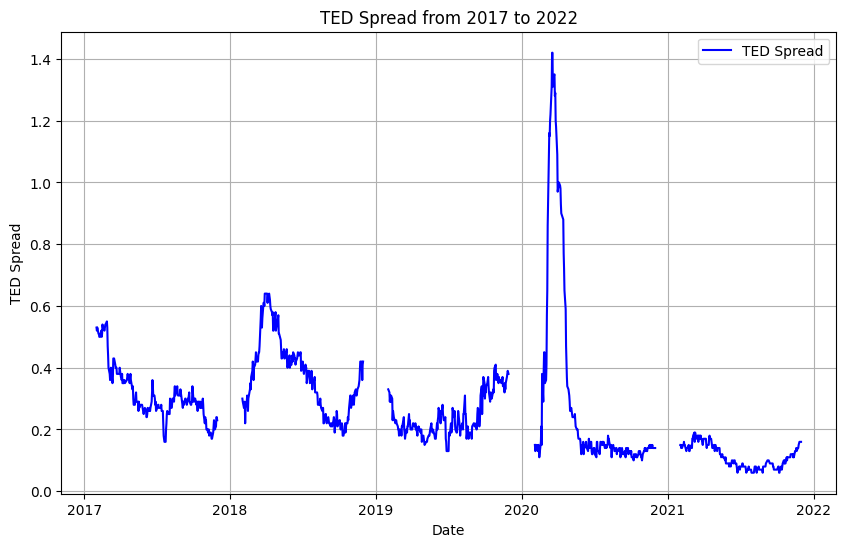

In [334]:
# @title
df_5_day_TED['Date'] = pd.to_datetime(df['Date'])

# Plotting the TED spread across the selected years
plt.figure(figsize=(10, 6))
plt.plot(df_5_day_TED['Date'], df_5_day_TED['TED'], label='TED Spread', color='blue')
plt.title('TED Spread from 2017 to 2022')
plt.xlabel('Date')
plt.ylabel('TED Spread')
plt.grid(True)
plt.legend()
plt.show()

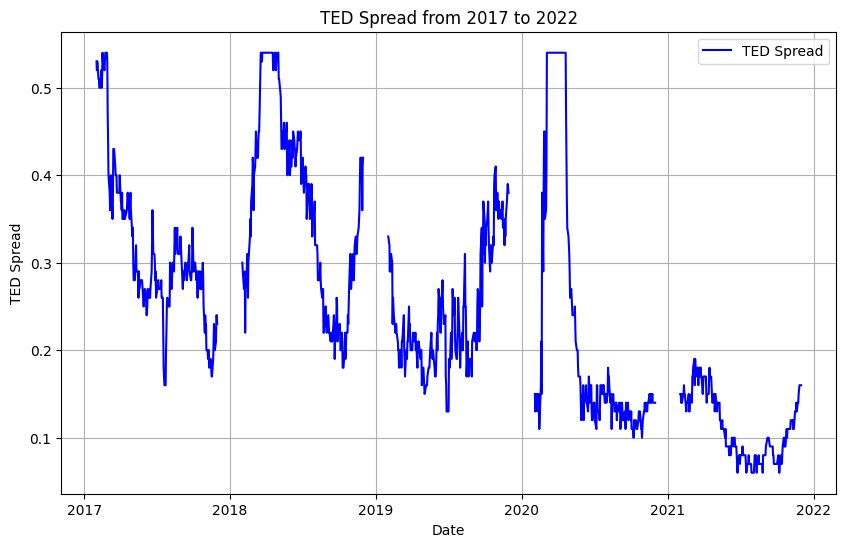

In [335]:
df_5_day_TED['Date'] = pd.to_datetime(df_5_day_TED['Date'])

df_5_day_TED['TED_winsorized'] = winsorize(df_5_day_TED['TED'], limits=(0, 0.05))

# Plotting the TED spread across the selected years
plt.figure(figsize=(10, 6))
plt.plot(df_5_day_TED['Date'], df_5_day_TED['TED_winsorized'], label='TED Spread', color='blue')
plt.title('TED Spread from 2017 to 2022')
plt.xlabel('Date')
plt.ylabel('TED Spread')
plt.grid(True)
plt.legend()
plt.show()

# **Regression with TED interaction**

In [336]:
# @title
## Main Script

# Initialize an empty list to store results
results = []

indices = ['FTSE100','FTSE250', 'FTSESmallCap']
#days_list = [1, 3, 5, 10]
days_list = [5]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day_TED']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract the month from the 'Date' column
        df['Month'] = df['Date'].dt.month

        df = df[df['festive'] == 0]

        # Calculate the Z-scores for TED values
        df['TED_z'] = zscore(df['TED'])

        # Define the threshold for extreme Z-scores (e.g., Z-scores > 2 or < -2)
        z_threshold = 2

         # Filter the DataFrame to include only rows where TED Z-score is within the normal range
        #df = df[(df['TED_z'] > -z_threshold) & (df['TED_z'] < z_threshold)]

        df['TED_winsorized'] = winsorize(df['TED'], limits=(0, 0.05))

        # Create dummy variables for the months
        month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)

        # Convert boolean dummy variables to integers
        month_dummies = month_dummies.astype(int)

        #df['TED*SWAV'] = df['Change in SWAV']*df['TED_category']
        df['Covid_Stringency*SWAV'] = df['Change in SWAV']*df['Stringency_Change']
        df['TED*SWAV'] = df['Change in SWAV']*df['TED_change']

        # Define the dependent variable
        y = df[f'% {index} Change']

        # Define the independent variables
        X = df[[  'Change in SWAV',
                  'ADS_Change',
                  'EPU_Change',
                   f'Previous % {index} Change',
                  '% MSCI Change',
                  'Vix Close',
                  'Rolling_Avg_Change_in_DCC',
                  'Stringency_Change',
                  'Covid_Stringency*SWAV',
                  'TED*SWAV',
                  'TED_change'
                ]]

        # Add the month dummies to the independent variables
        X = pd.concat([X, month_dummies], axis=1)

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            correlation = df[['Change in SWAV', 'TED']].corr()
            print(correlation)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Display the model summary
            print(model.summary())

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))
        else:
            result_row.append((None, None))  # Store None for both if no valid data

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Days']
for index in indices:
    columns.extend([f'{index} Coef'])  # Ensure you have columns for coefficients only

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: green')
                elif coef < 0:
                    colors.append('background-color: red')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

# Display the styled DataFrame
print("Multicollinearity checks done")
styled_df

<ipython-input-336-bc5cab25431d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TED_z'] = zscore(df['TED'])
<ipython-input-336-bc5cab25431d>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TED_winsorized'] = winsorize(df['TED'], limits=(0, 0.05))
<ipython-input-336-bc5cab25431d>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

KeyError: 'TED_change'